** Dataset test and validation are mixed together in one folder ** 

In [72]:
import os
import matplotlib.pyplot as plt
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img, save_img
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import cv2

import warnings

warnings.filterwarnings(action="ignore", category=Warning, module="tensorflow")
import logging
tf.get_logger().setLevel(logging.ERROR)

# Balance

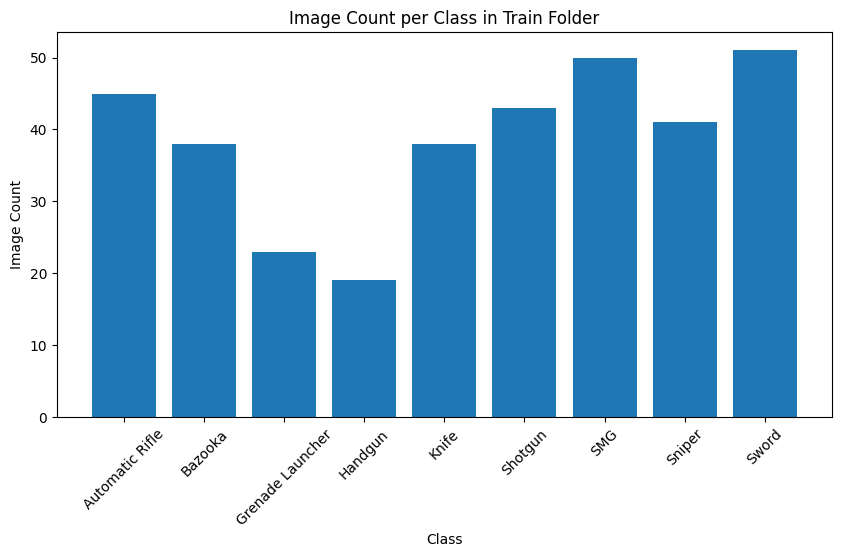

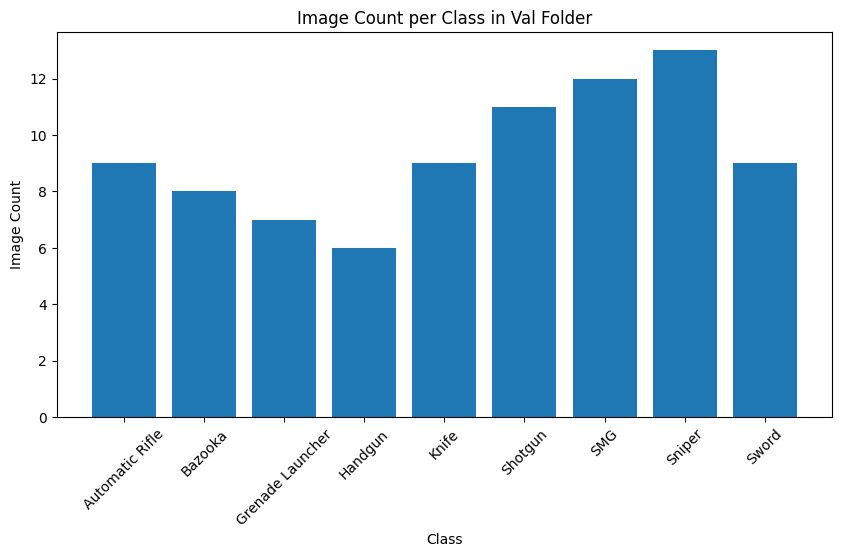

In [7]:
def plot_folder_counts(folder_path, title):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            class_counts[class_name] = count
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Image Count')
    plt.xticks(rotation=45)
    plt.show()

# Plot for train
plot_folder_counts('Weapons&B/train', 'Image Count per Class in Train Folder')

# Plot for val
plot_folder_counts('Weapons&B/val', 'Image Count per Class in Val Folder')

By OverSampling - SMOTE

In [ ]:
def augment_minority_classes(folder_path, target_count, augmentations=5):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            n_images = len(images)
            if n_images < target_count:
                print(f"Augmenting {class_name}: {n_images} -> {target_count}")
                while len(os.listdir(class_dir)) < target_count:
                    img_name = random.choice(images)
                    img_path = os.path.join(class_dir, img_name)
                    img = load_img(img_path)
                    x = img_to_array(img)
                    x = np.expand_dims(x, axis=0)
                    aug_iter = datagen.flow(x, batch_size=1)
                    aug_img = next(aug_iter)[0].astype('uint8')
                    new_img_name = f"aug_{random.randint(0, 1e7)}_{img_name}"
                    save_img(os.path.join(class_dir, new_img_name), aug_img)
    print("Augmentation complete.")

# Find the max class count
def get_max_class_count(folder_path):
    max_count = 0
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
            if count > max_count:
                max_count = count
    return max_count

In [10]:
target_count = get_max_class_count('Weapons&B/train')

In [11]:
augment_minority_classes('Weapons&B/train', target_count)

Augmenting Automatic Rifle: 45 -> 51
Augmenting Bazooka: 38 -> 51
Augmenting Grenade Launcher: 23 -> 51
Augmenting Handgun: 19 -> 51
Augmenting Knife: 38 -> 51
Augmenting Shotgun: 43 -> 51
Augmenting SMG: 50 -> 51
Augmenting Sniper: 41 -> 51
Augmentation complete.


-----

Without augmentation (just balance)

# Configuration

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 10
NUM_CLASSES = 9
DATA_DIR = "Weapons&B/trainMixVal"
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Resnet50 with no Augmentation and no Fine-Tune  

Data Generators

In [40]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # for one-hot encoded labels
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 438 images belonging to 9 classes.
Found 105 images belonging to 9 classes.


Model Definition

In [41]:
inputs = Input(shape=INPUT_SHAPE)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)

# Freeze the base model
base_model.trainable = False

# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

Compile Model

In [42]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Train Model

In [43]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.0873 - loss: 2.3146 - val_accuracy: 0.1238 - val_loss: 2.2027
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 825ms/step - accuracy: 0.1494 - loss: 2.1972 - val_accuracy: 0.1048 - val_loss: 2.1916
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 811ms/step - accuracy: 0.1875 - loss: 2.1737 - val_accuracy: 0.1524 - val_loss: 2.1697
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 845ms/step - accuracy: 0.2080 - loss: 2.1484 - val_accuracy: 0.2095 - val_loss: 2.1573
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 796ms/step - accuracy: 0.2905 - loss: 2.1103 - val_accuracy: 0.2286 - val_loss: 2.1474
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 856ms/step - accuracy: 0.3141 - loss: 2.0994 - val_accuracy: 0.2571 - val_loss: 2.1378
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 751ms/step - accuracy: 0.3166 - loss: 2.0914 - val_accuracy: 0.2667 - val_loss: 2.1280
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 770ms/step - accuracy: 0.2953 - loss: 2.0812 - val_accuracy: 0.2381 - val_loss: 2

Predict on a Folder of Images

In [45]:
folder = "Weapons&B/test"
for fname in os.listdir(folder):
    if fname.endswith(('.jpg', '.png', '.jpeg', '.gif')):
        path = os.path.join(folder, fname)
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        preds = model.predict(img_array)
        pred_class = list(train_generator.class_indices.keys())[np.argmax(preds[0])]
        print(f"{fname}: {pred_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
army.jpg: Sniper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
giphy.gif: SMG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
mafia-mafia-game.gif: Sword
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
weapons.jpg: Shotgun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
weapons2.jpg: Sniper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
weaponsgta5.gif: Automatic Rifle


In [ ]:
model.save("models/resnet50_no_a&f.keras")

------

# Resnet50 with Augmentation and no Fine-Tune

(Flipping + Brightness + Blur + Noise + Rotation + Zoom/Shift)

CUSTOM AUGMENTATION FUNCTION

In [66]:
def custom_preprocessing(img):
    img = img.astype(np.uint8)

    # 1. Apply random Gaussian blur (50% chance)
    if np.random.rand() < 0.5:
        img = cv2.GaussianBlur(img, (3, 3), sigmaX=1.0)

    # 2. Add Gaussian noise (50% chance)
    if np.random.rand() < 0.5:
        noise = np.random.normal(loc=0, scale=25, size=img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # 3. Normalize to [0, 1]
    return img / 255.0

IMAGE DATA GENERATOR WITH BUILT-IN + CUSTOM AUGMENTATIONS

In [67]:
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 438 images belonging to 9 classes.
Found 105 images belonging to 9 classes.


RESNET50 MODEL (FROZEN BASE)

In [68]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.1233 - loss: 2.3515

c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1236 - loss: 2.3442 - val_accuracy: 0.1143 - val_loss: 2.1968
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 959ms/step - accuracy: 0.1254 - loss: 2.2021 - val_accuracy: 0.1429 - val_loss: 2.1997
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 959ms/step - accuracy: 0.1026 - loss: 2.2093 - val_accuracy: 0.1333 - val_loss: 2.1804
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 984ms/step - accuracy: 0.1520 - loss: 2.1785 - val_accuracy: 0.1810 - val_loss: 2.1739
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 957ms/step - accuracy: 0.1560 - loss: 2.1796 - val_accuracy: 0.2286 - val_loss: 2.1605
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 951ms/step - accuracy: 0.1658 - loss: 2.1692 - val_accuracy: 0.2000 - val_loss: 2.1574
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 942ms/step - accuracy: 0.1827 - loss: 2.1596 - val_accuracy: 0.2000 - val_loss: 2.1540
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 972ms/step - accuracy: 0.1939 - loss: 2.1630 - val_accuracy: 0.1810 - val_loss: 2.1440
Epoch

In [74]:
folder = "Weapons&B/test"
for fname in os.listdir(folder):
    if fname.endswith(('.jpg', '.png', '.jpeg', '.gif')):
        path = os.path.join(folder, fname)
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        preds = model.predict(img_array)
        pred_class = list(train_generator.class_indices.keys())[np.argmax(preds[0])]
        print(f"{fname}: {pred_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
army.jpg: Shotgun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
giphy.gif: SMG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
mafia-mafia-game.gif: Sword
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
weapons.jpg: Grenade Launcher
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
weapons2.jpg: Shotgun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
weaponsgta5.gif: Shotgun


In [75]:
model.save("models/resnet50_a_no_f.keras")

# Resnet50 with Augmentation and Fine-Tune

In [76]:
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 20

CUSTOM PREPROCESSING FUNCTION

In [77]:
# Reduce blur
def custom_preprocessing(img):
    img = img.astype(np.uint8)

    # 1. Apply Gaussian blur with 30% chance
    if np.random.rand() < 0.3:
        img = cv2.GaussianBlur(img, (3, 3), sigmaX=1.0)

    # 2. Add Gaussian noise with 30% chance
    if np.random.rand() < 0.3:
        noise = np.random.normal(0, 10, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    return img / 255.0

DATA LOADERS

In [78]:
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 438 images belonging to 9 classes.
Found 105 images belonging to 9 classes.


BUILD RESNET MODEL

In [79]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
base_model.trainable = False  # Stage 1: Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

COMPILE (STAGE 1)

In [80]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

CALLBACKS

In [81]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3)
]

TRAIN (STAGE 1 - FROZEN BASE)

In [82]:
print("Stage 1: Training with frozen ResNet50")
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks
)

Stage 1: Training with frozen ResNet50
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.1055 - loss: 2.2883 - top_k_categorical_accuracy: 0.3217 - val_accuracy: 0.0857 - val_loss: 2.2179 - val_top_k_categorical_accuracy: 0.3429 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1210 - loss: 2.2147 - top_k_categorical_accuracy: 0.3680 - val_accuracy: 0.1429 - val_loss: 2.2121 - val_top_k_categorical_accuracy: 0.3333 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1592 - loss: 2.1842 - top_k_categorical_accuracy: 0.3594 - val_accuracy: 0.1048 - val_loss: 2.1818 - val_top_k_categorical_accuracy: 0.3810 - learning_rate: 0.0010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1411 - loss: 2.1817 - top_k_categorical_accuracy: 0.4013 - val_accuracy: 0.1238 - val_loss: 2.1786 - val_top_k_categorical_accuracy: 0.3714 - learning_rate: 0.0010
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 991ms/step - accuracy

STAGE 2: UNFREEZE LAST BLOCKS OF RESNET

In [83]:
print("Stage 2: Fine-tuning ResNet50")

for layer in base_model.layers:
    if 'conv5' in layer.name or 'conv4_block6' in layer.name:
        layer.trainable = True

# Lower LR for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)]
)

Stage 2: Fine-tuning ResNet50


TRAIN (STAGE 2 - FINE-TUNING)

In [84]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks
)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1352 - loss: 2.4809 - top_k_categorical_accuracy: 0.3618 - val_accuracy: 0.1619 - val_loss: 2.1395 - val_top_k_categorical_accuracy: 0.4286 - learning_rate: 1.0000e-05
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.1875 - loss: 2.2679 - top_k_categorical_accuracy: 0.4151 - val_accuracy: 0.1333 - val_loss: 2.1424 - val_top_k_categorical_accuracy: 0.4571 - learning_rate: 1.0000e-05
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2171 - loss: 2.0734 - top_k_categorical_accuracy: 0.5142 - val_accuracy: 0.1143 - val_loss: 2.1579 - val_top_k_categorical_accuracy: 0.4190 - learning_rate: 1.0000e-05
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2597 - loss: 2.0172 - top_k_categorical_accuracy: 0.5837 - val_accuracy: 0.1238 - val_loss: 2.1708 - val_top_k_categorical_accuracy: 0.3810 - learning_rate: 1.0000e-05
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.2972 - loss: 1.9523 - 

TEST

In [85]:
folder = "Weapons&B/test"
for fname in os.listdir(folder):
    if fname.endswith(('.jpg', '.png', '.jpeg', '.gif')):
        path = os.path.join(folder, fname)
        img = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        preds = model.predict(img_array)
        pred_class = list(train_generator.class_indices.keys())[np.argmax(preds[0])]
        print(f"{fname}: {pred_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
army.jpg: Sniper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
giphy.gif: SMG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
mafia-mafia-game.gif: Shotgun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
weapons.jpg: Shotgun
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
weapons2.jpg: Sniper
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
weaponsgta5.gif: Shotgun


In [ ]:
model.save("resnet50_a&f_1.keras")

# Resnet50 with Optimize preformance

Build a Tunable Model

In [94]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

In [95]:
def custom_preprocessing(img):
    img = img.astype(np.uint8)
    
    if np.random.rand() < 0.3:
        img = cv2.GaussianBlur(img, (3, 3), sigmaX=1.0)
        
    if np.random.rand() < 0.3:
        noise = np.random.normal(0, 10, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    return img / 255.0

# ====================
# DATA GENERATORS
# ====================
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# ====================
# MODEL BUILD FUNCTION FOR KERASTUNER
# ====================
def build_model(hp):
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False

    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    x = Dense(
        hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu')(x)

    x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)

    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# ====================
# TUNER SETUP
# ====================
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='kerastuner_logs',
    project_name='resnet50_weapon'
)

# ====================
# HYPERPARAMETER SEARCH
# ====================
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]
)

# ====================
# BEST MODEL
# ====================
best_model = tuner.get_best_models(1)[0]

Trial 2 Complete [00h 00m 00s]

Best val_accuracy So Far: None
Total elapsed time: 00h 00m 00s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |128               |dense_units
0.4               |0.2               |dropout
0.01              |0.0001            |learning_rate



Traceback (most recent call last):
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 309, in run_trial
    self._configure_tensorboard_dir(callbacks, trial, execution)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 421, in _configure_tensorboard_dir
    from tensorboard.plugins.hparams import api as hparams_api
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\api.py"

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 309, in run_trial
    self._configure_tensorboard_dir(callbacks, trial, execution)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 421, in _configure_tensorboard_dir
    from tensorboard.plugins.hparams import api as hparams_api
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\api.py", line 113, in <module>
    from tensorboard.plugins.hparams import _keras
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\_keras.py", line 24, in <module>
    from tensorboard.plugins.hparams import summary
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\summary.py", line 41, in <module>
    from tensorboard.plugins.hparams import metadata
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\metadata.py", line 32, in <module>
    NULL_TENSOR = tensor_util.make_tensor_proto(
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\util\tensor_util.py", line 405, in make_tensor_proto
    numpy_dtype = dtypes.as_dtype(nparray.dtype)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py", line 677, in as_dtype
    if type_value.type == np.string_ or type_value.type == np.unicode_:
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\numpy\__init__.py", line 413, in __getattr__
    error_message = f"{_wn.category.__name__}: {str(_wn.message)}"
AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_` instead.


Start the Tuning Search

In [91]:
import numpy as np

In [92]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="weapon_classification"
)

tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[]  # Disable default TensorBoard callback
)

# Best model
best_model = tuner.get_best_models(num_models=1)[0]

Reloading Tuner from tuner_logs\weapon_classification\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |128               |units
0.4               |0.3               |dropout
0.001             |0.0001            |learning_rate



Traceback (most recent call last):
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 309, in run_trial
    self._configure_tensorboard_dir(callbacks, trial, execution)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 421, in _configure_tensorboard_dir
    from tensorboard.plugins.hparams import api as hparams_api
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\api.py"

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 309, in run_trial
    self._configure_tensorboard_dir(callbacks, trial, execution)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\keras_tuner\src\engine\tuner.py", line 421, in _configure_tensorboard_dir
    from tensorboard.plugins.hparams import api as hparams_api
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\api.py", line 113, in <module>
    from tensorboard.plugins.hparams import _keras
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\_keras.py", line 24, in <module>
    from tensorboard.plugins.hparams import summary
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\summary.py", line 41, in <module>
    from tensorboard.plugins.hparams import metadata
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\plugins\hparams\metadata.py", line 32, in <module>
    NULL_TENSOR = tensor_util.make_tensor_proto(
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\util\tensor_util.py", line 405, in make_tensor_proto
    numpy_dtype = dtypes.as_dtype(nparray.dtype)
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py", line 677, in as_dtype
    if type_value.type == np.string_ or type_value.type == np.unicode_:
  File "c:\Users\ma.aldawsari\AppData\Local\anaconda3\envs\p\lib\site-packages\numpy\__init__.py", line 413, in __getattr__
    error_message = f"{_wn.category.__name__}: {str(_wn.message)}"
AttributeError: `np.string_` was removed in the NumPy 2.0 release. Use `np.bytes_` instead.
